In [1]:
import os
import math
import pefile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import collect_features
#import malware_utils

Соберём данные в init_df (initial dataframe):

In [2]:
# def get_init_df():
#     def collect_df(feature_extractor, pe_files_iterator):
#         samples = []
#         for pe, is_malware, path_to_pe_file in pe_files_iterator:
#             features = feature_extractor(pe)
#             features['is_malware'] = int(is_malware)
#             samples.append(features)
#             # print(path_to_pe_file)
#         return pd.DataFrame(samples)

#     folder_path = '../data/samples'
#     # Format: (folder, is_malware, limit)
#     paths_with_flags = (
#         (os.path.join(folder_path, 'clear'), False, 1000),
#         (os.path.join(folder_path, 'malware'), True, 1000),
#     )

#     init_df = collect_df(
#         collect_features.get_features,
#         malware_utils.iget_pe(paths_with_flags[:2])
#     )

#     init_df = init_df.sample(frac=1).reset_index(drop=True)
#     return init_df


# init_df = get_init_df()
# display(init_df)

Или загрузим уже готовый init_df:

In [3]:
from sklearn.externals import joblib

init_df = joblib.load('../data/init_df.pkl')
display(init_df)

,DIRECTORY_ENTRY/count,DIRECTORY_ENTRY_BOUND_IMPORT/exists,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_EXPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOSStub/zeros,...,SECTIONS/rsrc_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections,is_dll,is_driver,is_exe,is_malware
0,7,0,0,0,0,19,1,1,2.275327,0.713542,...,6.004603,2,6.487898,0,0,4,0,0,1,0
1,7,0,0,0,0,8,0,0,4.794355,0.125000,...,0.000000,1,7.170034,1,1,4,0,0,1,1
2,7,0,0,0,1,6,1,0,5.056196,0.120000,...,4.641484,0,6.238371,0,0,1,0,0,1,0
3,7,0,1,0,0,12,1,0,5.018442,0.160000,...,5.833111,0,7.251778,1,0,1,0,0,1,1
4,7,0,0,0,0,6,1,0,4.794355,0.125000,...,5.067445,0,6.191553,1,2,3,0,0,1,1
5,7,0,1,0,0,7,1,0,4.876573,0.136364,...,4.480931,0,6.540206,0,0,1,0,0,1,0
6,7,0,0,0,0,2,0,0,4.795101,0.200000,...,0.000000,0,5.780942,0,0,1,0,0,1,0
7,7,0,0,0,0,5,1,0,4.770738,0.210526,...,7.998516,0,5.020423,0,0,1,0,0,1,0
8,7,0,0,0,0,3,1,0,2.275327,0.713542,...,2.630648,1,0.000000,3,0,3,0,0,1,1
9,7,0,0,0,0,4,1,0,4.794355,0.125000,...,4.732696,1,6.080452,0,2,5,0,0,1,1


* Будем анализировать только exe-файлы (из-за малого количества dll и drivers). Соответственно, исключим из датасета файлы, которые не являются exe-файлами. Следовательно, нужно убрать признаки 'is_dll', 'is_driver', 'is_exe', а также 'FILE_HEADER.Characteristics/IMAGE_FILE_DLL'.
* Кроме того, исключим признаки: 'DIRECTORY_ENTRY/count', так как у всех образцов значение этого признака равно 7.

In [9]:
filtered_init_df = init_df[init_df['is_exe'] == 1]
filtered_init_df = filtered_init_df.drop(
    ['is_exe', 'is_dll', 'is_driver'],
    axis=1
)
filtered_init_df = filtered_init_df.drop(
    ['DIRECTORY_ENTRY/count',
     'FILE_HEADER.Characteristics/IMAGE_FILE_DLL',
     'FILE_HEADER.Characteristics/IMAGE_FILE_EXECUTABLE_IMAGE',
     'NTHeaders.Signature',
     'OPTIONAL_HEADER.FileAlignment/isAlignment',
     'OPTIONAL_HEADER.ImageBase/alignment'],
    axis=1
)

display(filtered_init_df)

,DIRECTORY_ENTRY_BOUND_IMPORT/exists,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_EXPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOSStub/zeros,DOS_HEADER.e_cblp,...,SECTIONS/entry_point_in_writeable_section,SECTIONS/executable_sections,SECTIONS/max_section_entropy,SECTIONS/rsrc_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections,is_malware
0,0,0,0,0,19,1,1,2.275327,0.713542,80,...,0,2,6.640694,6.004603,2,6.487898,0,0,4,0
1,0,0,0,0,8,0,0,4.794355,0.125000,144,...,0,2,7.170034,0.000000,1,7.170034,1,1,4,1
2,0,0,0,1,6,1,0,5.056196,0.120000,144,...,0,1,6.238371,4.641484,0,6.238371,0,0,1,0
3,0,1,0,0,12,1,0,5.018442,0.160000,144,...,0,2,7.251778,5.833111,0,7.251778,1,0,1,1
4,0,0,0,0,6,1,0,4.794355,0.125000,144,...,2147483648,3,6.191553,5.067445,0,6.191553,1,2,3,1
5,0,1,0,0,7,1,0,4.876573,0.136364,144,...,0,1,6.540206,4.480931,0,6.540206,0,0,1,0
6,0,0,0,0,2,0,0,4.795101,0.200000,144,...,0,1,5.780942,0.000000,0,5.780942,0,0,1,0
7,0,0,0,0,5,1,0,4.770738,0.210526,144,...,0,1,7.998516,7.998516,0,5.020423,0,0,1,0
8,0,0,0,0,3,1,0,2.275327,0.713542,80,...,0,1,6.728109,2.630648,1,0.000000,3,0,3,1
9,0,0,0,0,4,1,0,4.794355,0.125000,144,...,2147483648,2,6.080452,4.732696,1,6.080452,0,2,5,1


На данном этапе мы располагаем следующими данными:

* всего 54432 exe-файла
* из них 27402 файла являются вредоносными (malware)
* остальные 27030 являются чистыми (clear)

In [46]:
# filtered_init_df.isnull().sum()
# (scaled_df['OPTIONAL_HEADER.Reserved1'])
# scaled_df.groupby('FILE_HEADER.Characteristics/IMAGE_FILE_SYSTEM').nunique()

Нормализуем данные, избавившись от нормализации столбца 'is_malware':

In [13]:
from sklearn.preprocessing import StandardScaler

# filtered_init_df = filtered_init_df.fillna(0.0)

scaler = StandardScaler()

scaled_df = scaler.fit_transform(filtered_init_df)
scaled_df = pd.DataFrame(scaled_df, columns=filtered_init_df.columns)
scaled_df.loc[scaled_df.is_malware > 0, 'is_malware'] = 1
scaled_df.loc[scaled_df.is_malware < 0, 'is_malware'] = 0

display(scaler.mean_)
display(scaler.var_)

array([  1.89851558e-01,   3.78747795e-01,   2.16967960e-01,
         8.48214286e-02,   7.79030717e+00,   8.99654615e-01,
         2.04622281e-01,   4.39527479e+00,   2.57128751e-01,
         1.52020154e+02,   4.59290858e+01,   2.56214727e+01,
         1.76208848e+01,   1.56726925e+01,   1.36676955e+01,
         5.35784098e+01,   2.99907628e+02,   1.84386188e+02,
         6.52748755e+04,   2.19449405e+01,   3.51895870e+02,
         3.02961163e+02,   1.25031452e+02,   9.82179600e-01,
         9.65369636e-01,   1.21803902e+01,   1.32642563e-02,
         4.22545561e-04,   9.50451940e-01,   2.22295708e-03,
         1.59465021e-01,   1.59850823e-01,   6.05709877e-02,
         8.02101705e-02,   6.14656820e-01,   5.94246032e-01,
         9.99412111e-03,   6.37694738e-01,   1.77652851e-02,
         4.22545561e-04,   9.18577307e-05,   1.74238760e+03,
         5.17122281e+00,   2.73761356e+06,   4.04312935e+06,
         2.24715021e+02,   1.24941964e+06,   9.97666814e-01,
         1.23158542e+05,

array([  1.69587878e+00,   2.29397365e+01,   2.08861714e+00,
         7.76267538e-02,   1.02430419e+02,   9.02761888e-02,
         1.62752003e-01,   1.43364871e+00,   5.92756881e-02,
         4.96028497e+05,   1.18972144e+06,   5.05583816e+05,
         3.97902764e+05,   4.74253025e+05,   5.11732667e+05,
         2.13499754e+06,   1.22002258e+07,   4.85250920e+06,
         1.32160056e+07,   4.75491679e+05,   1.42138553e+07,
         1.26565043e+07,   3.41549806e+06,   1.75028331e-02,
         3.34311023e-02,   3.43304772e+05,   1.30883158e-02,
         4.22367017e-04,   4.70930497e-02,   2.21801555e-03,
         1.34035928e-01,   1.34298537e-01,   5.69021431e-02,
         7.37764990e-02,   2.36853814e-01,   2.41117686e-01,
         9.89423865e-03,   2.31040159e-01,   1.74496798e-02,
         4.22367017e-04,   9.18492929e-05,   4.61418918e+07,
         5.21013748e+00,   4.81666315e+15,   1.19530069e+16,
         1.55957415e+01,   1.14731682e+15,   2.32774260e-03,
         2.80552027e+12,

Сохраним при необходимости готовые данные на диск:

In [5]:
from sklearn.externals import joblib
joblib.dump(scaled_df, '../data/scaled_df.pkl')

['../data/scaled_df.pkl']

Загрузим готовые для анализа данные:

In [8]:
from sklearn.externals import joblib
scaled_df = joblib.load('../data/scaled_df.pkl')
# display(scaled_df[scaled_df['is_malware'] == 0])
# display(scaled_df.iloc[:, [23, 106]])
display(scaled_df)

,DIRECTORY_ENTRY_BOUND_IMPORT/exists,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_EXPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOSStub/zeros,DOS_HEADER.e_cblp,...,SECTIONS/entry_point_in_writeable_section,SECTIONS/executable_sections,SECTIONS/max_section_entropy,SECTIONS/rsrc_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections,is_malware
0,-0.145786,-0.079078,-0.150130,-0.304439,1.107591,0.333973,1.971561,-1.770532,1.874648,-0.102259,...,-0.452174,0.569053,-0.154830,0.743415,1.182910,0.558309,-0.460900,-0.288560,1.028014,0.0
1,-0.145786,-0.079078,-0.150130,-0.304439,0.020719,-2.994258,-0.507212,0.333303,-0.542699,-0.011388,...,-0.452174,0.569053,0.488182,-2.024843,0.258948,0.819053,0.131280,0.518246,1.028014,1.0
2,-0.145786,-0.079078,-0.150130,3.284733,-0.176894,0.333973,-0.507212,0.551986,-0.563236,-0.011388,...,-0.452174,-0.269120,-0.643547,0.114987,-0.665014,0.462928,-0.460900,-0.288560,-0.655287,0.0
3,-0.145786,0.129710,-0.150130,-0.304439,0.415945,0.333973,-0.507212,0.520455,-0.398942,-0.011388,...,-0.452174,0.569053,0.587479,0.664353,-0.665014,0.850299,0.131280,-0.288560,-0.655287,1.0
4,-0.145786,-0.079078,-0.150130,-0.304439,-0.176894,0.333973,-0.507212,0.333303,-0.542699,-0.011388,...,2.211540,1.407226,-0.700420,0.311364,-0.665014,0.445032,0.131280,1.325052,0.466914,1.0
5,-0.145786,0.129710,-0.150130,-0.304439,-0.078087,0.333973,-0.507212,0.401969,-0.496025,-0.011388,...,-0.452174,-0.269120,-0.276896,0.040968,-0.665014,0.578303,-0.460900,-0.288560,-0.655287,0.0
6,-0.145786,-0.079078,-0.150130,-0.304439,-0.572120,-2.994258,-0.507212,0.333925,-0.234648,-0.011388,...,-0.452174,-0.269120,-1.199206,-2.024843,-0.665014,0.288078,-0.460900,-0.288560,-0.655287,0.0
7,-0.145786,-0.079078,-0.150130,-0.304439,-0.275700,0.333973,-0.507212,0.313578,-0.191413,-0.011388,...,-0.452174,-0.269120,1.494573,1.662654,-0.665014,-0.002628,-0.460900,-0.288560,-0.655287,0.0
8,-0.145786,-0.079078,-0.150130,-0.304439,-0.473313,0.333973,-0.507212,-1.770532,1.874648,-0.102259,...,-0.452174,-0.269120,-0.048643,-0.812055,0.258948,-1.921663,1.315639,-0.288560,0.466914,1.0
9,-0.145786,-0.079078,-0.150130,-0.304439,-0.374507,0.333973,-0.507212,0.333303,-0.542699,-0.011388,...,2.211540,0.569053,-0.835379,0.157037,0.258948,0.402564,-0.460900,1.325052,1.589115,1.0


Посмотрим, как 2 случайных признака коррелируют между собой:

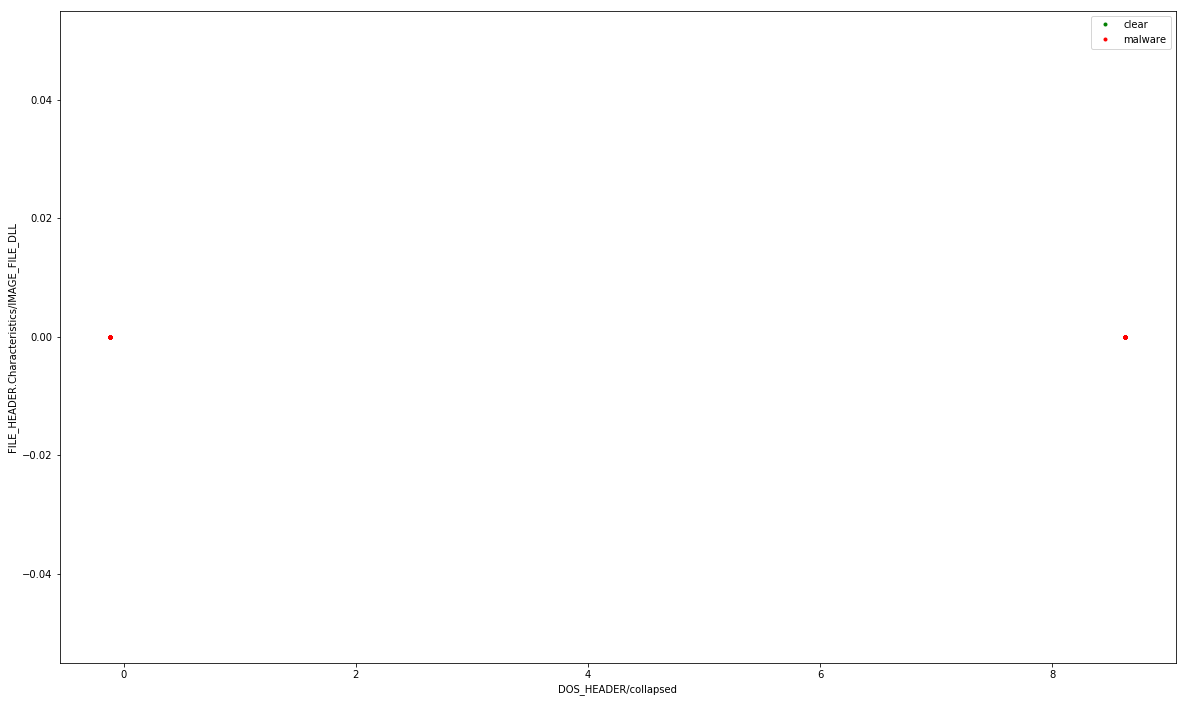

In [18]:
from cycler import cycler


groups = scaled_df.groupby('is_malware')
attr1 = 'DOS_HEADER/collapsed'
attr2 = 'FILE_HEADER.Characteristics/IMAGE_FILE_DLL'

fig, ax = plt.subplots(figsize=(20, 12))
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling
ax.set_prop_cycle(cycler('color', ['green', 'red', 'yellow']))
for name, group in groups:
    ax.plot(
        getattr(group, attr1),
        getattr(group, attr2),
        marker='o',
        linestyle='',
        ms=3,
        label=('malware' if name else 'clear')
    )

plt.xlabel(attr1)
plt.ylabel(attr2)
ax.legend()

plt.savefig(
    '../results/knn/correlation/'
    + 'SECTIONS_rsrc_section_entropy_vs_DOSStub_entropy'
    + '.svg',
    format='svg',
    dpi=1200
)
plt.show()

Поделим данные на обучающую и тестовую выборки, сохраним их на диск:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


scaled_df = scaled_df.sample(frac=1).reset_index(drop=True)
y = scaled_df['is_malware']
X = scaled_df.drop(['is_malware'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=13
)

# joblib.dump(X_train, '../data/X_train.pkl')
# joblib.dump(X_test,  '../data/X_test.pkl')
# joblib.dump(y_train, '../data/y_train.pkl')
# joblib.dump(y_test,  '../data/y_test.pkl')

['../tmp/1467_y_test.pkl']

Подготовка данных завершена!

Можно переходить к обучению!